In [10]:
import statsmodels.api as sm

In [1]:
from data_loader import DataGenerator
from datetime import datetime
# from model import lstm_builder, cnn_builder
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        ModelCheckpoint, TensorBoard)
from tensorflow.keras.backend import clear_session
import numpy as np
import warnings
from config import (model_config, data_generator_config, load_from_file,
                    n_epochs, model_name, n_validation_baches,
                    tb_logs_path, model_checkpoint_file)

warnings.filterwarnings("ignore")
np.random.seed(0)
clear_session()


def generator_wrapper(generator):
    while True:
        X = next(generator)
        X_len = X.shape[0]
        idx = np.random.randint(0, X_len, X_len)
        yield X[idx], X[idx]


now = datetime.now()
print("loading generator...", end=" ")
data_generator = DataGenerator(**data_generator_config)
print("done")
batch_size = 500 # data_generator_config['batch_size']
sample_len = data_generator_config['sample_len']
print("loading_data...", end=" ")
if load_from_file:
    quality_threshold = data_generator_config['quality_threshold']
    normalize = data_generator_config['normalize']
    test = data_generator_config['test']
#     data_generator.load_from_file((f"1000_{sample_len}_"
#                                    f"{quality_threshold}_"
#                                    f"{normalize}_{test}.npy"))
    data_generator.load_from_file((f"1000_{sample_len}_"
                                   f"{quality_threshold}_"
                                   f"{normalize}_{test}.npy"),
                                  new_batch_size=batch_size)
print(datetime.now() - now)

val_X = data_generator.get_validation_data(n_validation_baches)
val_X = val_X.reshape(n_validation_baches*batch_size, sample_len, 1)

steps_per_epoch = data_generator.data.shape[0]
gen = generator_wrapper(data_generator)

# model = cnn_builder(**model_config)


loading generator... /tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB07/*.fast5
done
loading_data... 0:00:09.365059


In [21]:
from matplotlib import pyplot as plt
sams = next(data_generator)
sam = next(data_generator)[0]

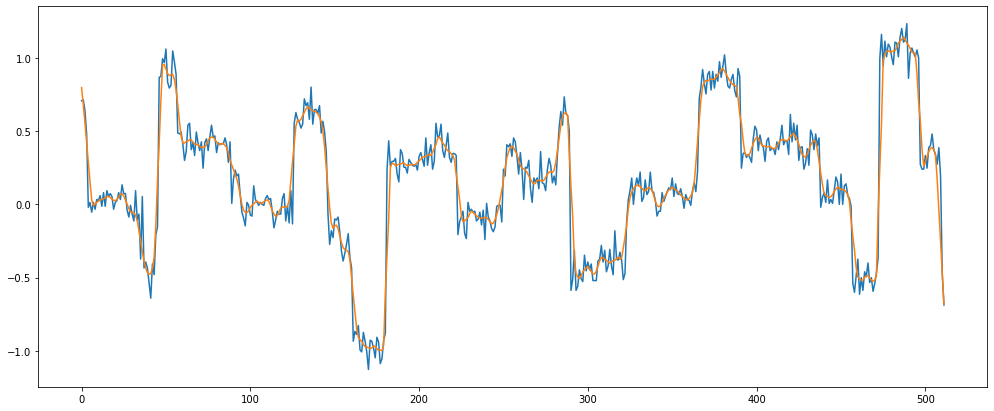

In [22]:
lowess = sm.nonparametric.lowess
window_size = 8
frac = window_size / len(sam)
plt.figure(figsize=(17,7))
plt.plot(sam)
plt.plot(lowess(sam.reshape(-1), np.arange(len(sam)), frac=frac, return_sorted=False))
plt.show()

In [24]:
from datetime import datetime
from tqdm import tqdm
now = datetime.now()
for sam in tqdm(sams):
    lowess(sam.reshape(-1), np.arange(len(sam)), frac=frac, return_sorted=False)
print(datetime.now() - now)

 26%|██▌       | 130/500 [00:35<01:41,  3.66it/s]


KeyboardInterrupt: 

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Conv1D, AveragePooling1D, ELU, GRU,
                                     UpSampling1D, Bidirectional, LSTM,
                                     RepeatVector, TimeDistributed, Dense,
                                     BatchNormalization, Concatenate)
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.optimizers import Adam

K.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
np.random.seed(0)
timesteps = 512

opt = Adam(learning_rate=0.01)
input_ = keras.Input(shape=(timesteps, 1))
first = Bidirectional(LSTM(125, return_sequences=True))(input_)
second = Bidirectional(LSTM(50, return_sequences=False))(first)
rv = RepeatVector(timesteps)(second)
dec = Bidirectional(LSTM(50, return_sequences=True))(rv)
dec = Bidirectional(LSTM(125, return_sequences=True))(dec)
decoded = TimeDistributed(Dense(1))(dec)
autoencoder = keras.Model(input_, decoded)
autoencoder.compile(optimizer=opt, loss='mae')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 1)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 512, 250)          96000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               90600     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 512, 100)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512, 100)          45600     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512, 250)          170250    
_________________________________________________________________
time_distributed (TimeDistri (None, 512, 1)            251   

In [7]:
autoencoder.fit(gen, steps_per_epoch=steps_per_epoch, epochs=n_epochs,
                validation_data=(val_X, val_X),
                validation_steps=n_validation_baches)

  ...
    to  
  ['...']
Train for 8284 steps, validate on 500000 samples
Epoch 1/100
  92/8284 [..............................] - ETA: 1:06:55 - loss: 0.4323

KeyboardInterrupt: 

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Conv1D, AveragePooling1D, ELU, 
                                     UpSampling1D, Bidirectional, LSTM,
                                     RepeatVector, TimeDistributed, Dense,
                                     BatchNormalization, Concatenate)
from tensorflow.keras import backend as K
import numpy as np

K.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
np.random.seed(0)


def cnn_builder(timesteps=300, inner=32, first_and_last=64, input_dim=1,
                  num_of_inner_conv=3, filter_size=12, loss='mse'):
    input_ = keras.Input(shape=(timesteps, input_dim))
    x = Conv1D(first_and_last, filter_size, 
                      activation=ELU(alpha=1), padding='same')(input_)
    for _ in range(num_of_inner_conv):
        x = AveragePooling1D(2, padding='same')(x)
        x = Conv1D(inner, filter_size, activation=ELU(alpha=1), padding='same')(x)
    encoded = AveragePooling1D(2, padding='same')(x)

    middle = Conv1D(1, filter_size, activation=ELU(alpha=1), padding='same')(encoded)
    
    x = UpSampling1D(2)(middle)
    for _ in range(num_of_inner_conv - 1):
        x = Conv1D(inner, filter_size, activation=ELU(alpha=1), padding='same')(x)
        x = UpSampling1D(2)(x)
    x = Conv1D(first_and_last, filter_size, activation=ELU(alpha=1), padding='same')(x)
    x = UpSampling1D(2)(x)
    decoded = Conv1D(1, filter_size, activation='linear', padding='same')(x)
    autoencoder = keras.Model(input_, decoded)
    autoencoder.compile(optimizer='adadelta', loss=loss)
    return autoencoder

def lstm_builder(timesteps, loss='mse', **kwargs):
    input_ = keras.Input(shape=(timesteps, 1))
    x = Conv1D(kwargs['inner'], kwargs['filter_size'], padding='valid')(input_)
    x = ELU(alpha=1)(x)
    x = AveragePooling1D(2, padding='same')(x)
    
    x = Conv1D(kwargs['inner'], kwargs['filter_size'], padding='valid')(x)
    x = BatchNormalization()(x)
    x = ELU(alpha=1)(x)
    x = AveragePooling1D(2, padding='valid')(x)
    
    encoded = LSTM(120, activation='linear', recurrent_dropout=0.1)(x)
    x = BatchNormalization()(encoded)
    
    decoded_seq = Dense(timesteps, activation='linear')(x)
    autoencoder = keras.Model(input_, decoded_seq)
    autoencoder.compile(optimizer='adam', loss=loss)
    return autoencoder


def lstm_builder(timesteps, loss='mse', **kwargs):
    input_ = keras.Input(shape=(timesteps, 1))
    x = Conv1D(kwargs['inner'], kwargs['filter_size'], padding='valid')(input_)
    x = ELU(alpha=1)(x)
    x = AveragePooling1D(2, padding='same')(x)
    
    x = Conv1D(kwargs['inner'], kwargs['filter_size'], padding='valid')(x)
    x = BatchNormalization()(x)
    x = ELU(alpha=1)(x)
    x = AveragePooling1D(2, padding='valid')(x)
    
    encoded = LSTM(120, activation='linear', recurrent_dropout=0.1)(x)
    x = BatchNormalization()(encoded)
    
    decoded_seq = Dense(timesteps, activation='linear')(x)
    autoencoder = keras.Model(input_, decoded_seq)
    autoencoder.compile(optimizer='adam', loss=loss)
    return autoencoder



def unet_builder(timesteps, loss='mse', compile=False, **kwargs):
    
    def down_block(filters, x, name="down_block"):
        x = Conv1D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = ELU(alpha=1)(x)
        x = Conv1D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        elu = ELU(alpha=1)(x)
        return elu
    
    def up_block(filters, input1, input2, name="up_block"):
        x = Conv1D(filters, 3, padding='same')(input1)
        elu = ELU(alpha=1)(x)
        x = Concatenate(axis=2)([input2, x])
        x = Conv1D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        elu = ELU(alpha=1)(x)
        x = Conv1D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        elu = ELU(alpha=1)(x)
        return elu
    
    input_ = keras.Input(shape=(timesteps, 1))

    first = down_block(16, input_)
    x = AveragePooling1D(4, padding='same')(first)
    second = down_block(32, x)
    x = AveragePooling1D(4, padding='same')(second)
    third = down_block(64, x)
    x = AveragePooling1D(4, padding='same')(third)
    fourth = down_block(128, x)
    x = AveragePooling1D(4, padding='same')(fourth)
    fifth = down_block(256, x)
    
    x = UpSampling1D(4)(fifth)
    x = up_block(128, x, fourth)
    x = UpSampling1D(4)(x)
    x = up_block(64, x, third)
    x = UpSampling1D(4)(x)
    x = up_block(32, x, second)
    x = UpSampling1D(4)(x)
    x = up_block(16, x, first)
    
    out = Conv1D(1, 1, padding='same')(x)

    unet = keras.Model(input_, out)
    if compile:
        unet.compile(optimizer='adam', loss=loss)
    return unet


In [15]:
model = unet_builder(timesteps=512, loss='mae', compile=True)

es = EarlyStopping(monitor='val_loss', mode='min', patience=10,
                   restore_best_weights=False)
lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1,
                          min_lr=0.0001)
mc = ModelCheckpoint(filepath=model_checkpoint_file,
                     save_best_only=True)
# tb = TensorBoard(log_dir=tb_logs_path, histogram_freq=2)
# callbacks = [es, lr_cb, mc, tb]

history = model.fit(gen, steps_per_epoch=steps_per_epoch, epochs=n_epochs,
#                     callbacks=callbacks, verbose=1,
                    validation_data=(val_X, val_X),
                    validation_steps=n_validation_baches)
# model.save(model_name)


  ...
    to  
  ['...']
Train for 3721 steps, validate on 1000000 samples
Epoch 1/100
1700/3721 [============>.................] - ETA: 2:02 - loss: 0.0269

KeyboardInterrupt: 

In [20]:
from notify_run.keras import NotifyCallback

ModuleNotFoundError: No module named 'keras'